In [1]:
# import modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix,
    plot_confusion_matrix, make_scorer,multilabel_confusion_matrix,ConfusionMatrixDisplay, classification_report)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from xgboost import XGBClassifier

from CF_5_Modelling import (add_model_score, feat_imp, scorer_pos_neg_class,
                            scorer_confusion_matrix)

rng = 847666577 #int(np.random.default_rng().random()*(2**32))

%qtconsole

In [2]:
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\processed\\'
data_final_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\final\\'
docs_img_dir = 'C:\\Users\\bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\docs\\img\\'

In [3]:
def plot_train_test_scoring(model, param, param_range,smote=False):
    train_score = pd.DataFrame(columns=['param','recall_functional','recall_needs_repair','recall_non-functional',
                                       'prec_functional','prec_needs_repair','prec_non-functional'])
    test_score = pd.DataFrame(columns=['param','recall_functional','recall_needs_repair','recall_non-functional',
                                       'prec_functional','prec_needs_repair','prec_non-functional'])
    
    if smote : 
        X_train_func = X_train_smote
        y_train_func = y_train_smote
    else:
        X_train_func = X_train
        y_train_func = y_train
    
    for i in param_range:
        
        grid_params = {
            'scaler' : [StandardScaler()],
            param : [i]
        }
        
        pipe = GridSearchCV(Pipeline([('scaler',scaler),('feat_sel',feat_sel),('model',model)]),scoring='recall',cv=5,param_grid=grid_params,n_jobs=-1)
        
        pipe.fit(X_train_func,y_train_func)
        
        y_train_pred = pipe.predict(X_train_func)
        y_test_pred = pipe.predict(X_test)
        
        recall_train = recall_score(y_train_func,y_train_pred,labels=[0,1,2],average=None)
        precision_train = precision_score(y_train_func,y_train_pred,labels=[0,1,2],average=None)
        
        recall_test = recall_score(y_test,y_test_pred,labels=[0,1,2],average=None)
        precision_test = precision_score(y_test,y_test_pred,labels=[0,1,2],average=None)
        
        train_score_iter = pd.DataFrame([[i,recall_train[0],recall_train[1],recall_train[2],
                                         precision_train[0],precision_train[1],precision_train[2]]],
                                        columns=['param','recall_functional','recall_needs_repair','recall_non-functional',
                                                 'prec_functional','prec_needs_repair','prec_non-functional'])
        
        test_score_iter = pd.DataFrame([[i,recall_test[0],recall_test[1],recall_test[2],
                                         precision_test[0],precision_test[1],precision_test[2]]],
                                        columns=['param','recall_functional','recall_needs_repair','recall_non-functional',
                                                 'prec_functional','prec_needs_repair','prec_non-functional'])
        
        
        train_score = pd.concat([train_score,train_score_iter])
        test_score = pd.concat([test_score,test_score_iter])
    
    return train_score, test_score
    
# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes,n_layers,trainX, trainy, testX, testy):
    
    #configure the model based on the data
    n_input, n_classes = trainX.shape[1], len(set(testy))
    
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=100, activation='relu'))
    
    for layer in range(0,n_layers-1):
        model.add(Dense(n_nodes,input_dim=100,activation='relu'))
        
    model.add(Dense(3, activation='softmax'))# compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # fit model on train set
    history = model.fit(trainX, to_categorical(trainy), epochs=100, verbose=0)
    
    # evaluate model on test set
    _, test_acc = model.evaluate(testX, to_categorical(testy), verbose=0)
    
    return history, test_acc

def optimize_nn(num_nodes,num_layers,X,y,cv_splits=5):

    plt.figure(figsize=(15,7))

    num_nodes = num_nodes
    num_layers= num_layers

    smote = SMOTE(random_state=42)

    kfold = KFold(n_splits=cv_splits, shuffle=True,random_state=42)

    y_k = pd.Series(y)

    for nodes in num_nodes:

        res_avg = np.array([])

        for layer in num_layers:

            for train, test in kfold.split(X,y_k):

                X_train_smote, y_train_smote = smote.fit_sample(X.loc[train,:],y_k[train])

                history, results = evaluate_model(nodes,layer,X_train_smote,y_train_smote,X.loc[test,:],y_k[test])

                plt.plot(history.history['loss'],label=str(nodes))

                res_avg = np.append(res_avg,results)

            res_avg = res_avg.mean()

            print('nodes=%d, layers=%d : %.3f' % (nodes,layer,res_avg))    

    plt.axis(ymax=10,ymin=0)
    plt.legend()
    return plt.show()    


In [4]:
df_train = pd.read_csv(data_processed_dir+'training_data_encoded_impv2_geo-corr.csv')
print(df_train.shape)
print(df_train.columns)
df_train.head(2)


(59400, 102)
Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'district_code', 'population', 'public_meeting', 'permit', 'pump_age',
       ...
       'source_shallow well', 'source_spring', 'source_unknown',
       'source_class_groundwater', 'source_class_surface',
       'source_class_unknown', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple',
       'waterpoint_type_hand pump', 'waterpoint_type_other'],
      dtype='object', length=102)


,id,amount_tsh,gps_height,longitude,latitude,district_code,population,public_meeting,permit,pump_age,...,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other
0,69572,6000.0,1390,34.938093,-9.856322,5,109,1,1,12.0,...,0,1,0,1,0,0,1,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,2,280,1,1,3.0,...,0,0,0,0,1,0,1,0,0,0


In [5]:
print(df_train['status_group'].value_counts(normalize=True))

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


In [6]:
df_col = df_train.columns.to_list()

X = df_train.drop(['id','status_group'],axis=1)

label_enc = LabelEncoder()

y = label_enc.fit_transform(df_train['status_group'])

label_dict = dict(zip(list(set(y)),label_enc.inverse_transform(list(set(y))).tolist()))

X.head()

,amount_tsh,gps_height,longitude,latitude,district_code,population,public_meeting,permit,pump_age,installer_Commu,...,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other
0,6000.0,1390,34.938093,-9.856322,5,109,1,1,12.0,0,...,0,1,0,1,0,0,1,0,0,0
1,0.0,1399,34.698766,-2.147466,2,280,1,1,3.0,0,...,0,0,0,0,1,0,1,0,0,0
2,25.0,686,37.460664,-3.821329,4,250,1,1,4.0,0,...,0,0,0,0,1,0,0,1,0,0
3,0.0,263,38.486161,-11.155298,63,58,1,1,27.0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.0,0,31.130847,-1.825359,1,0,1,1,25.0,0,...,0,0,0,0,1,0,1,0,0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(pd.Series(y_train).value_counts().sort_index())

0    24161
1     3243
2    17146
dtype: int64


In [8]:
# SMOTE training editing
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)

print(pd.Series(y_train_smote).value_counts())

2    24161
1    24161
0    24161
dtype: int64


## RFC Base

In [9]:
model = RandomForestClassifier(random_state=123)
scaler = StandardScaler()
feat_sel = SelectKBest(score_func=f_classif)

In [10]:
grid_params = {
    'scaler' : [StandardScaler()], #, MinMaxScaler(),None],
    'feat_sel__k': [100], #np.arange(1,X.shape[1]+1,step=1),
    'model__random_state': [123], #np.arange(start=1, stop = 10000),
    'model__n_estimators': [148], #np.arange(130,180,step=1),
    'model__max_depth': [14], #np.arange(1,15,step=1),
    'model__criterion': ['entropy'], #['gini','entropy']
}

RFC_base_pipe = GridSearchCV(Pipeline([('scaler',scaler),('feat_sel',feat_sel),('model',model)]),scoring='recall_weighted',cv=5,param_grid=grid_params,n_jobs=-1)

RFC_base_pipe.fit(X_train,y_train)

y_pred = RFC_base_pipe.predict(X_test)

                         precision    recall  f1-score   support

             functional       0.74      0.95      0.83      8098
functional needs repair       0.72      0.18      0.29      1074
         non functional       0.89      0.66      0.76      5678

               accuracy                           0.78     14850
              macro avg       0.78      0.60      0.63     14850
           weighted avg       0.80      0.78      0.77     14850



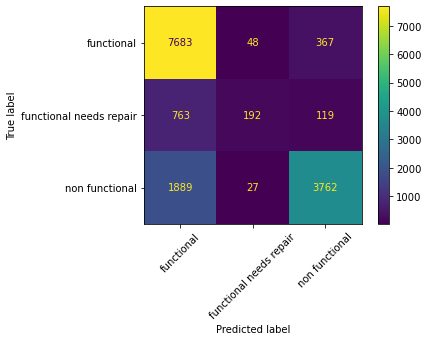

In [11]:
print(classification_report(y_test,y_pred,target_names=list(label_dict.values())))
plot_confusion_matrix(RFC_base_pipe,X_test,y_test,display_labels=list(label_dict.values()),xticks_rotation=45)

In [12]:
feat_imp = pd.Series(RFC_base_pipe.best_estimator_.named_steps.model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp

quantity_dry                          0.135222
longitude                             0.073651
latitude                              0.070701
pump_age                              0.058996
extraction_type_class_other           0.044458
                                        ...   
installer_KKKT                        0.000534
source_class_unknown                  0.000434
source_other                          0.000423
extraction_type_class_wind-powered    0.000262
source_unknown                        0.000171
Length: 100, dtype: float64

## RFC Base w/SMOTE

                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      8098
functional needs repair       0.42      0.43      0.43      1074
         non functional       0.81      0.78      0.80      5678

               accuracy                           0.79     14850
              macro avg       0.68      0.68      0.68     14850
           weighted avg       0.79      0.79      0.79     14850



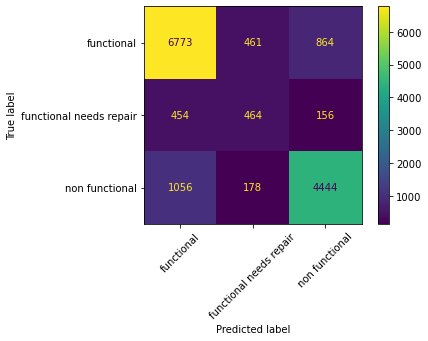

In [13]:
grid_params = {
    'scaler' : [StandardScaler()], #, MinMaxScaler(),None],
    'feat_sel__k': [100], #np.arange(10,X.shape[1]+1,step=10),
    'model__n_estimators': [386], #np.arange(370,390,step=1),
    #'model__min_samples_split' : np.arange(6,40,step=2),
    'model__criterion': ['entropy'], #['gini','entropy']
}

RFC_base_pipe = GridSearchCV(Pipeline([('scaler',scaler),('feat_sel',feat_sel),('model',model)]),scoring='accuracy',cv=5,param_grid=grid_params,n_jobs=-1)

RFC_base_pipe.fit(X_train_smote,y_train_smote)

y_pred = RFC_base_pipe.predict(X_test)

print(classification_report(y_test,y_pred,target_names=list(label_dict.values())))
plot_confusion_matrix(RFC_base_pipe,X_test,y_test,display_labels=list(label_dict.values()),xticks_rotation=45)

In [14]:
feat_imp = pd.Series(RFC_base_pipe.best_estimator_.named_steps.model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp

longitude                             0.130954
latitude                              0.126768
gps_height                            0.059891
pump_age                              0.057365
quantity_dry                          0.049908
                                        ...   
installer_KKKT                        0.000534
source_class_unknown                  0.000525
source_other                          0.000307
extraction_type_class_wind-powered    0.000177
source_unknown                        0.000132
Length: 100, dtype: float64

## XGBoost

In [15]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree',use_label_encoder=False)
scaler = StandardScaler()
feat_sel = SelectKBest(score_func=f_classif)

C:\Users\bryan\Anaconda3\envs\kerascpu\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  category=UserWarning


[11:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                         precision    recall  f1-score   support

             functional       0.71      0.94      0.81      8098
functional needs repair       0.67      0.17      0.27      1074
         non functional       0.86      0.58      0.69      5678

               accuracy                           0.75     14850
              macro avg       0.75      0.57      0.59     14850
           weighted avg       0.77      0.75      0.73     14850



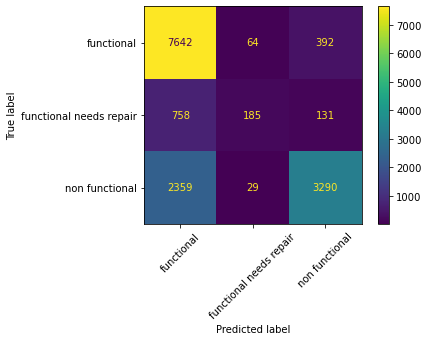

In [16]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree',use_label_encoder=False)

grid_params = {
    'model__learning_rate': [0.3], #np.arange(0.1,1.1,step=0.1),
    'model__n_estimators': np.arange(10,50),
    #'model__max_depth' : np.arange(1,10,step=1),
    #'model__gamma' : [0.6], #np.arange(0,1,step=0.1),
    #'model__lambda' : np.arange(0,1.1,step=0.1),
    #'model__alpha' : [0], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]    
}

XGB_base_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring='recall',cv=5,param_grid=grid_params,n_jobs=-1)

XGB_base_pipe.fit(X_train,y_train)

y_pred = XGB_base_pipe.predict(X_test)

print(classification_report(y_test,y_pred,target_names=list(label_dict.values())))
plot_confusion_matrix(XGB_base_pipe,X_test,y_test,display_labels=list(label_dict.values()),xticks_rotation=45)

## XGBoost SMOTE

[11:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      8098
functional needs repair       0.43      0.43      0.43      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.79     14850
              macro avg       0.69      0.68      0.69     14850
           weighted avg       0.79      0.79      0.79     14850



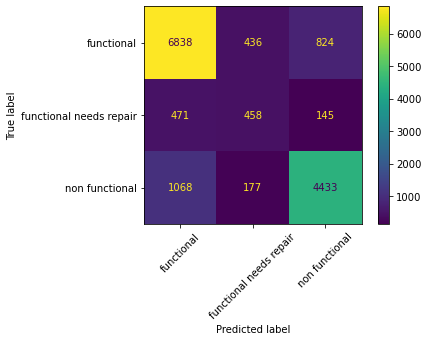

In [17]:
grid_params = {
    'model__learning_rate': [0.4], #np.arange(0.1,1,step=0.1),
    'model__n_estimators': [100], #[10,50,100,200,500],
    'model__max_depth' : [16], #np.arange(5,20,step=1),
    'model__gamma' : [0], #np.arange(0,1.1,step=0.1),
    'model__lambda' : [0.8], #np.arange(0,1.1,step=0.1),
    'model__alpha' : [0.7], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()], #, MinMaxScaler(),None]
    'feat_sel__k': [100] #np.arange(50,X.shape[1]+1,step=1),
}

XGB_base_pipe = GridSearchCV(Pipeline([('scaler',scaler),('feat_sel',feat_sel),('model',model)]),scoring='accuracy',cv=5,param_grid=grid_params,n_jobs=-1)

XGB_base_pipe.fit(X_train_smote,y_train_smote)

y_pred = XGB_base_pipe.predict(X_test)

print(classification_report(y_test,y_pred,target_names=list(label_dict.values())))
plot_confusion_matrix(XGB_base_pipe,X_test,y_test,display_labels=list(label_dict.values()),xticks_rotation=45)

## Neural Network

In [18]:
from keras.models import Sequential
from keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score

n_feat = X_train_smote.shape[1]
n_out = len(set(y_train_smote))

def baseline_model(optimizer='adam'):
    model = Sequential()
    
    model.add(Dense(51,activation='relu',input_dim=n_feat))
    model.add(Dense(51,activation='relu'))
    model.add(Dense(51,activation='relu'))
    model.add(Dense(n_out,activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    return model

Using TensorFlow backend.
C:\Users\bryan\Anaconda3\envs\kerascpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bryan\Anaconda3\envs\kerascpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bryan\Anaconda3\envs\kerascpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bryan\Anaconda3\envs\kerascpu

In [19]:
scaler = StandardScaler()
estimator = KerasClassifier(build_fn=baseline_model,verbose=0)

grid_params={
    'nn__epochs' : [200],
    'nn__batch_size' : [54],
    'nn__optimizer' : ['Nadam']
}

NN_pipe = GridSearchCV(Pipeline([('scaler',scaler),('nn',estimator)]),cv=10,param_grid=grid_params,
                       n_jobs=-1,return_train_score=True)

NN_pipe.fit(X_train_smote,y_train_smote)

C:\Users\bryan\Anaconda3\envs\kerascpu\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan]
  category=UserWarning


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DB4A46B4E0>)]),
             n_jobs=-1,
             param_grid={'nn__batch_size': [54], 'nn__epochs': [200],
                         'nn__optimizer': ['Nadam']},
             return_train_score=True)

In [20]:
y_pred = NN_pipe.predict(X_test)


print(classification_report(y_test,y_pred,target_names=list(label_dict.values())))

                         precision    recall  f1-score   support

             functional       0.79      0.77      0.78      8098
functional needs repair       0.30      0.47      0.36      1074
         non functional       0.78      0.71      0.75      5678

               accuracy                           0.73     14850
              macro avg       0.62      0.65      0.63     14850
           weighted avg       0.75      0.73      0.74     14850



## Output Data Submission :

In [21]:
df_test = pd.read_csv(data_processed_dir+'test_data_encoded_impv2_geo-corr.csv')
X_submission = df_test.drop(['id','status_group'],axis=1)

X_submission.head()

,amount_tsh,gps_height,longitude,latitude,district_code,population,public_meeting,permit,pump_age,installer_Commu,...,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other
0,0.0,1996,35.290799,-4.059696,3,321,1,1,1.0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,1569,36.656709,-3.309214,2,300,1,1,13.0,0,...,0,1,0,1,0,0,1,0,0,0
2,0.0,1567,34.767863,-5.004344,2,500,1,0,3.0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,267,38.058046,-9.418672,43,250,1,1,26.0,0,...,1,0,0,1,0,0,0,0,0,1
4,500.0,1260,35.006123,-10.950412,3,60,1,1,13.0,0,...,0,1,0,1,0,0,1,0,0,0


In [22]:
sub_results = NN_pipe.predict(X_submission)

df_sub = pd.concat([df_test['id'],pd.Series(label_enc.inverse_transform(sub_results),name='status_group')],axis=1).set_index('id')

df_sub.to_csv(data_final_dir+'submission.csv')